# TSA Claim Reimbursement Predictor

By: Israel Fernandez, Haider Syed

Objective: The objective of this report is to write a machine learning algorithm to answer some crucial questions that people may have when taking flights with valuable belongings. We will illustrate the likelyhood of getting a refund, what percentage of what you ask for you might actually get reimbursed, and whether or not you should feel comfortable taking said belongings to the airport.

In [42]:
# All imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from IPython.display import display, HTML
from scipy import stats

We took data from https://www.kaggle.com/datasets/terminal-security-agency/tsa-claims-database/data

In [43]:
df = pd.read_csv('tsa_claims.csv')

C:\Users\israe\AppData\Local\Temp\ipykernel_9140\3021715513.py:1: DtypeWarning: Columns (0,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tsa_claims.csv')


The dataset contains information about claims that were made against the TSA for property damage, lost or damaged property. These claims are generally filed against the TSA for personal injuries, lost or damaged property during screenings. 

This dataset is the record of claims between 2002 - 2015 recoreded by the TSA.

The dataset contains the following data:

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204267 entries, 0 to 204266
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Claim Number   204267 non-null  object
 1   Date Received  204004 non-null  object
 2   Incident Date  202084 non-null  object
 3   Airport Code   195743 non-null  object
 4   Airport Name   195743 non-null  object
 5   Airline Name   169893 non-null  object
 6   Claim Type     196354 non-null  object
 7   Claim Site     203527 non-null  object
 8   Item           200301 non-null  object
 9   Claim Amount   200224 non-null  object
 10  Status         204262 non-null  object
 11  Close Amount   135315 non-null  object
 12  Disposition    131359 non-null  object
dtypes: object(13)
memory usage: 20.3+ MB


The data contains a lot of information that, although is good to have, is not necessary for our purposes. We are going to clean it up a bit.

In [45]:
# Helper function to clean data
def clean_data(col):
    cleaned_data = df[col].str.replace("$", "", regex=False).str.replace(";","").str.replace(" ", "").replace("-",float("NaN"))
    return cleaned_data.convert_dtypes(float)
# Clean the claim amounts to floats
df["Claim Amount"] = clean_data('Claim Amount')
df['Close Amount'] = clean_data('Close Amount')
# Drop NA values for Close Amount and Claim Amount as they are not important
df = df.dropna(subset = ['Close Amount'])
df = df.dropna(subset = ['Claim Amount'])

# We do not need Airline Names. We will be using Airline Codes
df = df.drop('Airline Name', axis=1)

# Ignore Items that do not have a description
df = df.dropna(subset = ['Item'])



Now we are going to only focus on the most common 15 items.

In [46]:
# Get top 15 most common 
item_counts = df['Item'].value_counts()
items_to_keep = item_counts.head(15).index
df = df[df['Item'].isin(items_to_keep)]
df = df[df['Item'] != 'Other']

Lets see just how much of a representation we have of the entire dataset:

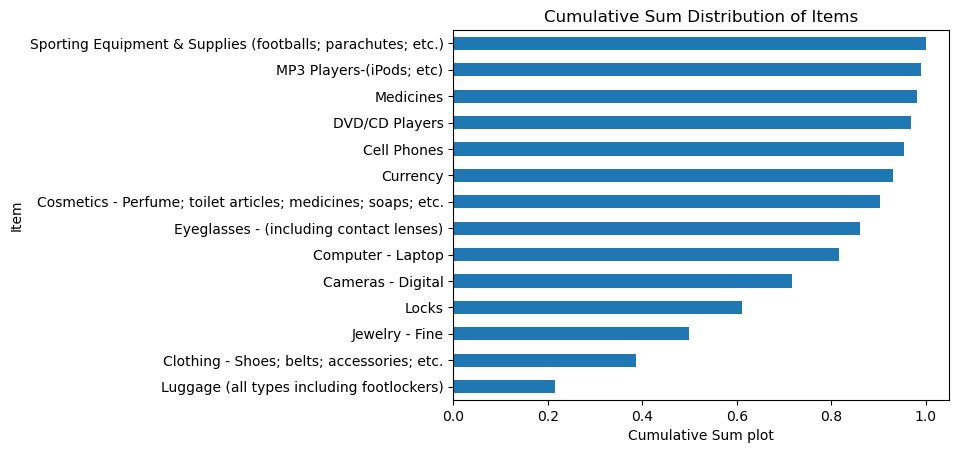

In [47]:
df['Item'].value_counts(normalize = True).cumsum().plot.barh()
plt.ylabel('Item')
plt.xlabel('Cumulative Sum plot')
plt.title('Cumulative Sum Distribution of Items');

The plot shows where the majority of our data lies. Seems like the majority of items are DVD/CD Players and below. We need to narrow our scope a lot more because we want to be able to display meaningful plots. Lets take a look at what happens if we attempt to view our data as it is even after preprocessing

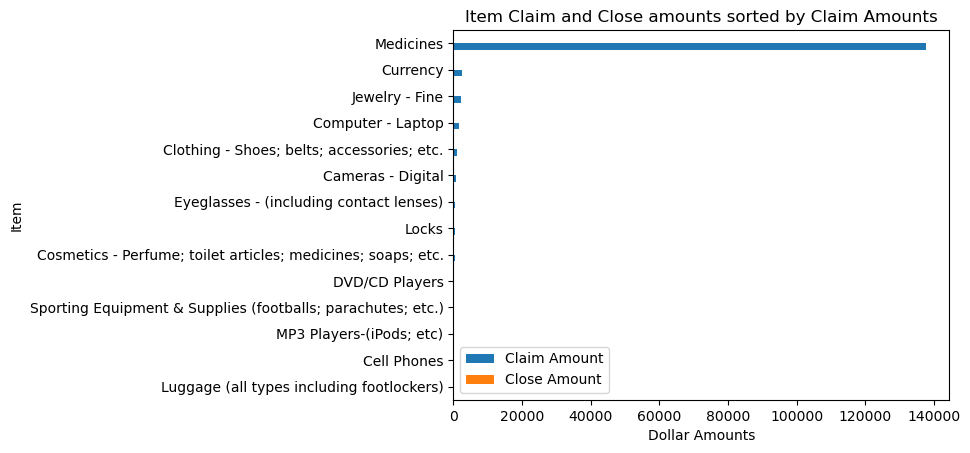

In [64]:
df['Claim Amount'] = pd.to_numeric(df['Claim Amount'], errors='coerce')
df['Close Amount'] = pd.to_numeric(df['Close Amount'], errors='coerce')
df.groupby("Item")[['Claim Amount', 'Close Amount']].mean().sort_values(by="Claim Amount").plot.barh()
plt.xlabel('Dollar Amounts')
plt.title('Item Claim and Close amounts sorted by Claim Amounts');

Medicine seems to dominate our data because of how much money people want to claim due to lost or damaged medicine. This presents an issue for us because it dwarfs all of our other data. If you reference our previous plot, medicine does not represent a lot of our data so we should be able to ignore it as an outlier. Not useful to track medicine data if people are going to ask for egregious amounts in reimbursements. We will drop that part of the data.

In [69]:
df = df.drop(df[df["Item"] == "Medicines"].index)

Now we have gotten rid of the Medicines from our dataset. This should give us a better representation of our data.

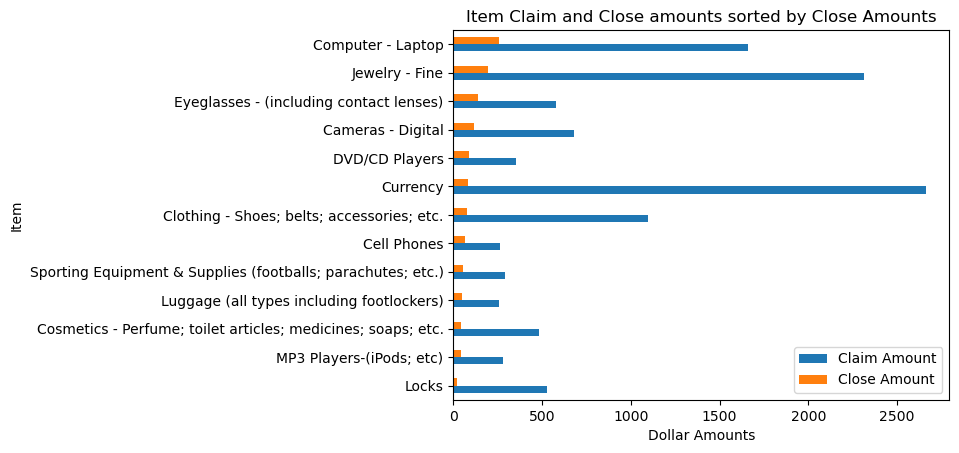

In [71]:
df.groupby("Item")[['Claim Amount', 'Close Amount']].mean().sort_values(by="Close Amount").plot.barh()
plt.xlabel('Dollar Amounts')
plt.title('Item Claim and Close amounts sorted by Close Amounts');

Now our data is significantly more readable. We have resorted our data so that we sort by Close Amount because that is what we want to start focusing on. From here we want to focus on percentage of Close Amount based on Claim Amount. That is to say, we want to know how much money would be reimbursed based on how much money was requested.

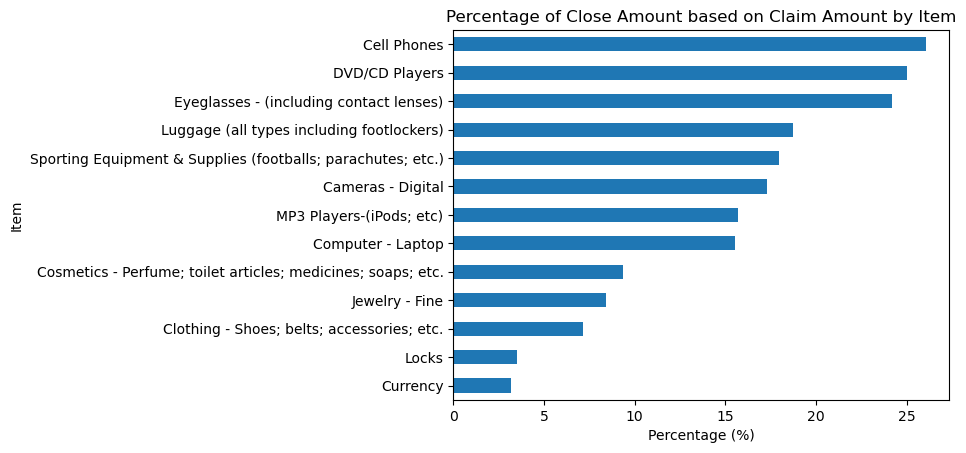

In [78]:
grouped = df.groupby("Item")[["Claim Amount", "Close Amount"]].mean()
grouped["Percentage"] = (grouped["Close Amount"] / grouped["Claim Amount"]) * 100
grouped = grouped.sort_values(by="Percentage")
grouped["Percentage"].plot.barh()
plt.xlabel('Percentage (%)')
plt.title('Percentage of Close Amount based on Claim Amount by Item');

Now we are getting somewhere. From the graph, it looks like if you were to request a reimbursement based on a lost/damanged Cell Phone you are likely to get about 25% reimbursement of the value of the item. It also looks like Currency is the least amount reimbursed due to loss/damage. It makes sense because it is much more difficult to prove that that item was actually lost. 